In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm

from flightmech.aircraft import Aircraft, AircraftState, load_aerodynamics
from flightmech.propulsion import Propeller
from flightmech.propulsion import PropulsionSystem

#@formatter:off
%reload_ext autoreload
#@formatter:on

prop = Propeller(d=2, zeta=0.7, P_max=50e3, n_v=-1)
propulsion = PropulsionSystem(propulsor=prop, n_prop=2)

ac = Aircraft(
    S=197,
    b=65,
    propulsion=propulsion,
    aerodynamics=load_aerodynamics('naca_2315'),
    m=2500
)

## Annahmen Wasserstoff

In [2]:
# Annahmen Wasserstoff
energy_density_hydrogen = 8 * 1e6  # kg * m^2 / s^2 / l
rho_hydrogen = 70.85  # g / L
eta_hydrogen_system = 0.72

## Flugzeugpolare

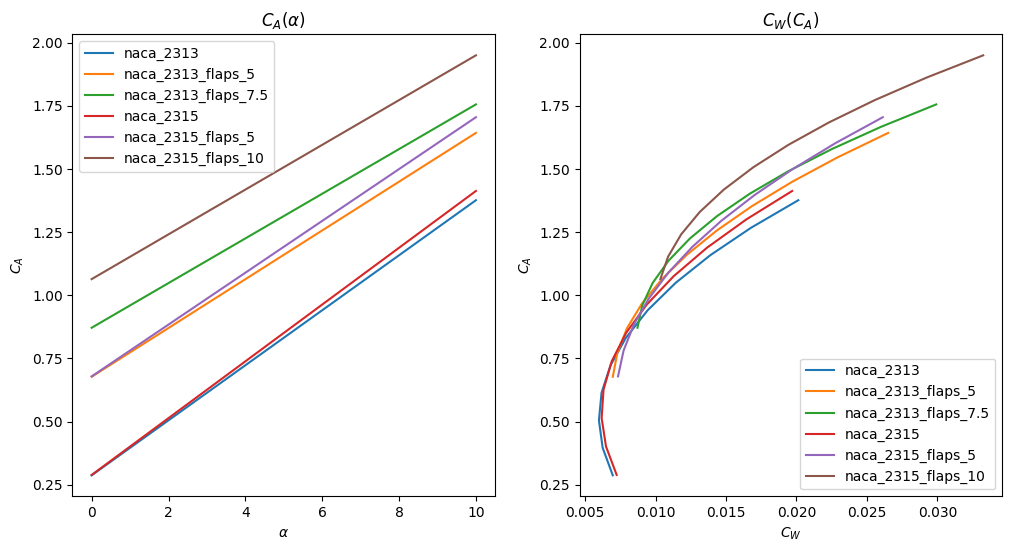

In [3]:
polare = [
    'naca_2313',
    'naca_2313_flaps_5',
    'naca_2313_flaps_7.5',
    'naca_2315',
    'naca_2315_flaps_5',
    'naca_2315_flaps_10'
]

# Auftriebspolare
alpha_range = np.arange(0, 11, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

for polar in polare:
    aerodynamics = load_aerodynamics(polar)
    C_A = [aerodynamics.C_A(alpha) for alpha in alpha_range]

    ax[0].set_title(r"$C_A(\alpha)$")
    ax[0].set_xlabel(r'$\alpha$')
    ax[0].set_ylabel(r'$C_A$')
    ax[0].plot(alpha_range, C_A, label=polar)
    ax[0].legend()

    C_W = [aerodynamics.C_W(alpha) for alpha in alpha_range]

    ax[1].set_title(r'$C_W(C_A)$')
    ax[1].set_xlabel(r'$C_W$')
    ax[1].set_ylabel(r'$C_A$')
    ax[1].plot(C_W, C_A, label=polar)
    ax[1].legend()

C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


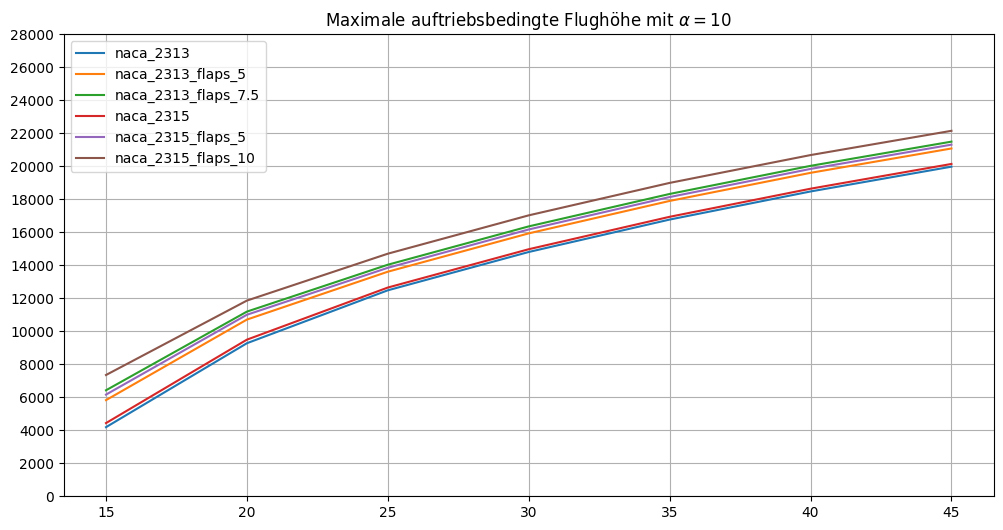

In [4]:
## Maximale auftriebsbedingte Flughöhe

#@formatter:off
%autoreload 2
#@formatter:on

x0_h_max = [1000]

bounds_h_max = [(0, np.infty)]
alpha = 10

ac.state.alpha = math.radians(alpha)
ac.state.theta = math.radians(alpha)


def lift_surplus(x):
    ac.state.s[2] = -x[0]
    return abs(ac.A() - ac.G())


# noinspection PyPep8Naming
def minimize_delta_Z(V: float):
    ac.state.V = np.array([V, 0, 0])
    result = minimize(lift_surplus, x0_h_max, bounds=bounds_h_max, method='trust-constr')
    if result.success:
        return result.x[0]


_, ax = plt.subplots(figsize=(12, 6))

V_range = np.arange(15, 50, 5)

max_h = []

for polar in polare:
    aerodynamics = load_aerodynamics(polar)
    ac.aerodynamics = aerodynamics
    max_h = [minimize_delta_Z(V) for V in V_range]

    ax.set_title(r"Maximale auftriebsbedingte Flughöhe mit $\alpha = 10$")
    ax.plot(V_range, max_h, label=polar)
    ax.legend()

ax.yaxis.set_ticks(np.arange(0, math.ceil(max(max_h) / 10e3) * 10e3, 2000))
ax.grid()

In [92]:
# Optimization for cruise
V = np.array([20, 0, 0])

alpha_0 = np.radians(3)
theta_0 = np.radians(4)
u_g_0 = 35
w_g_0 = 0
P_max_0 = 20e3
P_max = 60e3
d_rotor = 4

init_state = AircraftState(
    alpha=alpha_0,
    theta=theta_0,
    gamma=0,
    V=np.array([20, 0, 0]),
    a=np.array([0, 0, 0]),
    s=np.array([0, 0, -18300])
)

polar = 'naca_2315'

ac.aerodynamics = load_aerodynamics(polar)

x0_cruise = [P_max_0, alpha_0, u_g_0, w_g_0]

ac.state = init_state

iters = []
i = 0

bounds_cruise = [(5e3, P_max), (math.radians(0), math.radians(10)), (12, np.inf), (0, 0)]


# constr = LinearConstraint([0, -1, 1, 0, 0, 0], lb=0, ub=0)
def accel_z(x, kwargs):
    # Modify angles
    _ac = kwargs['aircraft']

    # Modify propeller characteristics
    _ac.propulsion.propulsor.P_max = x[0]

    # Modify aircraft state
    _ac.state.alpha = x[1]
    # Modify speed
    _ac.state.V = -np.array([x[2], 0, x[3]])
    _ac.state.update_gamma()
    _ac.state.theta = _ac.state.alpha + _ac.state.gamma

    # opt_vec = np.array([np.linalg.norm(_ac.accel())])
    return np.linalg.norm(_ac.accel())


def minimize_accel(_polar):
    _aerodynamics = load_aerodynamics(_polar)
    aircraft = ac
    ac.aerodynamics = _aerodynamics
    return minimize(accel_z, x0_cruise, method='trust-constr', bounds=bounds_cruise,
                    args={'aircraft': aircraft})


results = []

for polar in polare:
    res = minimize_accel(polar)
    alpha = math.degrees(res.x[1])
    C_A = ac.aerodynamics.C_A(alpha)
    C_W = ac.aerodynamics.C_W(alpha)
    gamma = -math.atan(res.x[3] / res.x[2])
    results.append({
        'airfoil': polar,
        'success': res.success,
        'alpha': alpha,
        'theta': alpha + gamma,
        'u_g': res.x[2],
        'w_g': res.x[3],
        'P_max': res.x[0],
        'C_A': C_A,
        'C_W': C_W,
        'gleitzahl': C_W / C_A
    })

C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: d

In [93]:
df = pd.DataFrame(results)
df = df.sort_values('gleitzahl')
df

,airfoil,success,alpha,theta,u_g,w_g,P_max,C_A,C_W,gleitzahl
0,naca_2313,True,8.847673,8.847673,41.351289,0.0,37490.145565,1.250914,0.016309,0.013038
3,naca_2315,False,9.379332,9.379332,39.901323,0.0,34005.608809,1.343294,0.017627,0.013122
4,naca_2315_flaps_5,True,8.854391,8.854391,36.703309,0.0,27802.690034,1.587545,0.022305,0.014050
1,naca_2313_flaps_5,False,9.999817,9.999817,36.092439,0.0,20227.476857,1.643028,0.026513,0.016137
2,naca_2313_flaps_7.5,True,9.688115,9.688115,35.165933,0.0,25801.595895,1.728279,0.028662,0.016584
5,naca_2315_flaps_10,True,9.895874,9.895874,33.181102,0.0,22462.086519,1.940999,0.032817,0.016907


## Energieverbrauch Cruise (Loitering)

In [94]:
P_max = 23e3 * 2
t = 168 * 3600

E_w_cruise = P_max * t  # Energiebedarf (Wellenleistung)

E_cruise = E_w_cruise / eta_hydrogen_system

vol_hydrogen = E_cruise / energy_density_hydrogen
m_hydrogen_cruise = rho_hydrogen * vol_hydrogen / 1000
specific_price_hydrogen = 6  # EUR / l

print(f'Required energy: {"{:.2f}".format(E_cruise / 3600 / 1000)} kWh')
print(
    f'Required liquid hydrogen volume: {"{:.2f}".format(vol_hydrogen)} L = {"{:.2f}".format(vol_hydrogen / 1000)} m^3')
print(f'Required hydrogen mass: {"{:.2f}".format(m_hydrogen_cruise)} kg')
print(f'Hydrogen specific price: {specific_price_hydrogen} EUR/l')
print(f'Price Hydrogen per loitering: {"{:.2f}".format(specific_price_hydrogen * m_hydrogen_cruise)} EUR')

Required energy: 10733.33 kWh
Required liquid hydrogen volume: 4830.00 L = 4.83 m^3
Required hydrogen mass: 342.21 kg
Hydrogen specific price: 6 EUR/l
Price Hydrogen per loitering: 2053.23 EUR


## Takeoff

In [8]:
ac.state.s = np.zeros(3)


def accel_z_optfn(x):
    ac.state.V = np.array([x[0], 0, 0])
    ac.state.alpha = x[1]
    return abs(ac.accel()[2])


bounds_takeoff = [(0, np.inf), (0, math.radians(3))]
x0_takeoff = [0, 0]


def minimize_dz(_polar):
    ac.aerodynamics = load_aerodynamics(_polar)
    return minimize(accel_z_optfn, x0_takeoff, method='trust-constr', bounds=bounds_takeoff)


to_data = []
for polar in polare:
    res = minimize_dz(polar)
    if res.success:
        to_data.append({
            'polare': polar,
            'V_to': res.x[0],
            'alpha_to': math.degrees(res.x[1])
        })

df = pd.DataFrame(to_data)
df

C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: d

,polare,V_to,alpha_to
0,naca_2313,18.630352,2.808241
1,naca_2313_flaps_5,15.615521,1.675634
2,naca_2313_flaps_7.5,13.905363,2.072728
3,naca_2315_flaps_5,15.211956,1.995969
4,naca_2315_flaps_10,12.503180,2.674717


## Energie Steigflug

In [77]:
from flightmech.utils import meters, feet
#@formatter:off
%autoreload 2
#@formatter:on

sel_polar = 'naca_2315_flaps_10'
ac.aerodynamics = load_aerodynamics(sel_polar)

h_tgt_feet = 60000
h_tgt_m = meters(h_tgt_feet)

ac.state.alpha = math.radians(3)
ac.state.theta = math.radians(2)

ac.state.s = np.zeros(3)
ac.state.V = np.array([13, 0, 0])
ac.state.a = np.zeros(3)

ac.propulsion.propulsor.P_max = 40e3  # kW
ac.propulsion.propulsor.d = 4.5  # m

dt = 0.01
k = 1e-5
t_climb = 0
data = []


def update_fn(_ac: Aircraft):
    if math.degrees(_ac.state.alpha) < _ac.aerodynamics.alpha_max:
        _d_alpha = k * _ac.state.V[0]
    else:
        _d_alpha = 0

    _ac.state.alpha += _d_alpha
    return _d_alpha, _ac.accel()


print(f'Calculating climb to {h_tgt_feet} feet with P_max = {ac.propulsion.propulsor.P_max}.')
with tqdm(total=h_tgt_feet) as pbar:
    while ac.state.h() <= h_tgt_m:
        d_alpha, new_accel = ac.update(dt, update_fn)

        data.append({
            'alpha': math.degrees(ac.state.alpha),
            'd_alpha': math.degrees(d_alpha),
            'theta': math.degrees(ac.state.theta),
            'gamma': math.degrees(ac.state.gamma),
            'h': ac.state.h(),
            'a_x': new_accel[0],
            'a_z': new_accel[2],
            'a': np.linalg.norm(new_accel),
            'V_g': np.linalg.norm(ac.state.V_g()),
            't': t_climb,
            'F': ac.F(),
            'A': ac.A(),
            'W': ac.W()
        })
        t_climb += dt

        pbar.update(feet(-ac.state.V[2] * dt))


Calculating climb to 60000 feet.


100%|█████████▉| 59983.83223318722/60000 [08:22<00:00, 235.59it/s] C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\tqdm\std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 60000.00642042846/60000 [08:22<00:00, 119.49it/s]


In [78]:
df = pd.DataFrame(data)
df = df.iloc[::100, :]
df['u_g'] = df['V_g'] * np.cos(np.radians(df['gamma']))
df['w_g'] = df['V_g'] * np.sin(np.radians(df['gamma']))

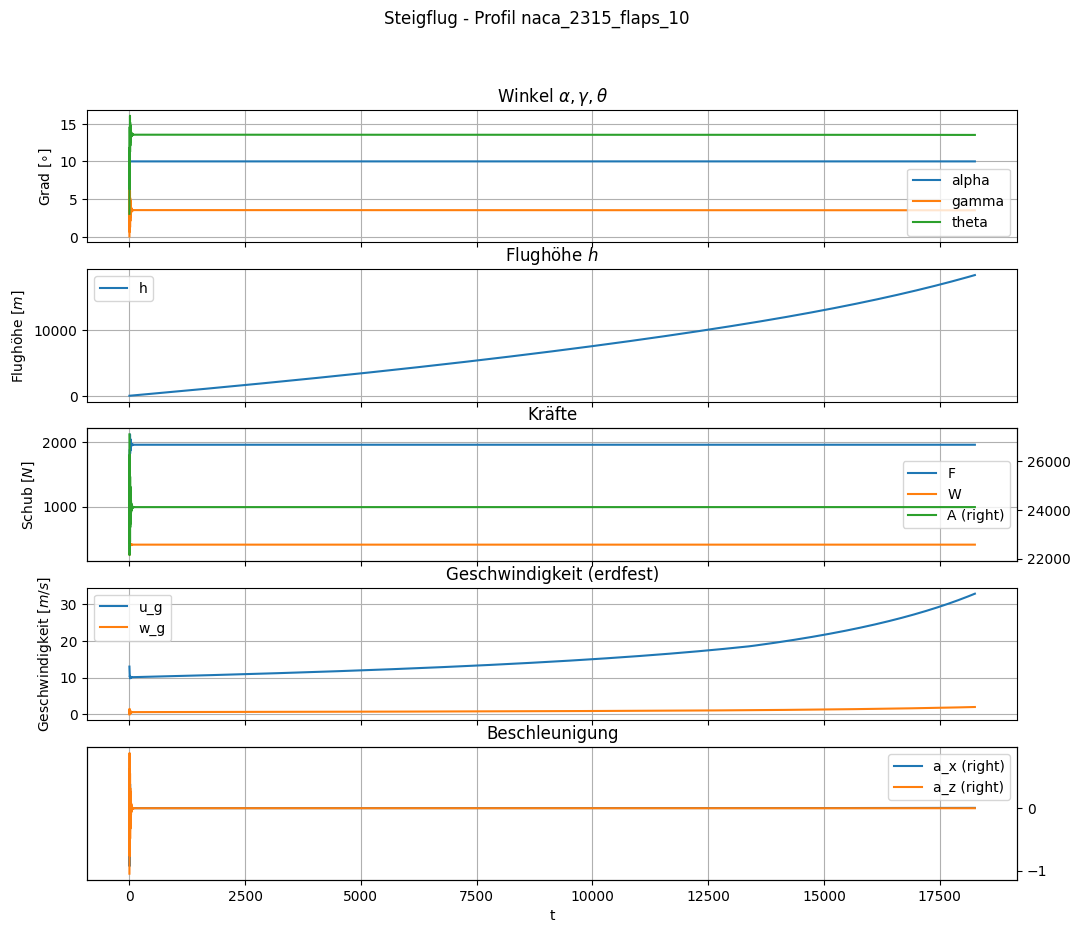

In [79]:
fig, ax = plt.subplots(5, 1, figsize=(12, 10))
ax = ax.flatten()

fig.suptitle(f'Steigflug - Profil {sel_polar}')

n_ax = 0
ax[n_ax].set_title(r'Winkel $\alpha, \gamma, \theta$')
ax[n_ax].set_ylabel(r'Grad $[\circ]$')
df.plot(x='t', y=['alpha', 'gamma', 'theta'], ax=ax[0])

n_ax += 1
ax[n_ax].set_title(r'Flughöhe $h$')
ax[n_ax].set_ylabel(r'Flughöhe $[m]$')
df.plot(x='t', y='h', ax=ax[n_ax], sharex=ax[0])

n_ax += 1
ax[n_ax].set_title(r'Kräfte')
ax[n_ax].set_ylabel(r'Schub $[N]$')
df.plot(x='t', y=['F', 'W'], ax=ax[n_ax], sharex=ax[0])
df.plot(x='t', y='A', ax=ax[n_ax], secondary_y=True, sharex=ax[0])

n_ax += 1
ax[n_ax].set_title(r'Geschwindigkeit (erdfest)')
ax[n_ax].set_ylabel(r'Geschwindigkeit $[m/s]$')
df.plot(x='t', y=['u_g', 'w_g'], ax=ax[n_ax], sharex=ax[0])

n_ax += 1
ax[n_ax].set_title(r'Beschleunigung')
ax[n_ax].set_ylabel(r'Beschleunigung $m/s^2$')
df.plot(x='t', y=['a_x', 'a_z'], secondary_y=True, ax=ax[n_ax], sharex=ax[0])

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
ax[4].grid()

## Energiebedarf Steigflug

In [95]:
hours = math.floor(t_climb / 3600)
minutes = math.floor((t_climb - hours * 3600) / 60)
seconds = math.floor(t_climb - minutes * 60 - hours * 3600)

E_w_climb = ac.propulsion.propulsor.P_max * t_climb  # Energiebedarf (Wellenleistung)

E_climb = E_w_climb / eta_hydrogen_system  # Energiebedarf Antriebssystem

vol_hydrogen_climb = E_climb / energy_density_hydrogen
m_hydrogen_climb = rho_hydrogen * vol_hydrogen_climb / 1000

print(
    f'Time to {h_tgt_feet} feet: {"{:02d}".format(hours)}:{"{:02d}".format(minutes)}:{"{:02d}".format(seconds)}h')

print(f'Required energy: {"{:.2f}".format(E_climb / 3600 / 1000)} kWh')
print(
    f'Required liquid hydrogen volume: {"{:.2f}".format(vol_hydrogen_climb)} L = {"{:.2f}".format(vol_hydrogen_climb / 1000)} m^3')
print(f'Required hydrogen mass: {"{:.2f}".format(m_hydrogen_climb)} kg')
print(f'Hydrogen specific price: {specific_price_hydrogen} EUR/l')
print(f'Price Hydrogen per loitering: {"{:.2f}".format(specific_price_hydrogen * m_hydrogen_climb)} EUR')

Time to 60000 feet: 05:04:21h
Required energy: 158.25 kWh
Required liquid hydrogen volume: 71.21 L = 0.07 m^3
Required hydrogen mass: 5.05 kg
Hydrogen specific price: 6 EUR/l
Price Hydrogen per loitering: 30.27 EUR
